In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

In [2]:
NB_EPOCH = 100
TIME_LIM = None # 25
BATCH_SIZE = 64


REPEAT_TIMES = 10

In [3]:
def make_2d_classification(N=4000, well_split=True):
    a_pos1 = torch.randn(N//4, 2) + torch.tensor([3.0, 2.0])
    a_pos2 = torch.randn(N//4, 2) + torch.tensor([-3.0, 3.0])
    if well_split:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -5.0])
    else:
        a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -2.0])
    data = torch.cat([a_pos1, a_pos2, a_neg], dim=0)
    data = (data - data.mean(axis=0)) / np.sqrt(data.var(axis=0))
    labels = torch.cat([torch.ones(N//2), torch.zeros(N//2)])
    return TensorDataset(data, labels)

In [4]:
# cifar_classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
    # [transforms.ToTensor(),
    #  transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [6]:
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    # filtered_data = (data[mask] / 255).float()
    
    scaler = StandardScaler()
    filtered_data = torch.from_numpy(scaler.fit_transform(data[mask])).float()

    # filtered_data = (filtered_data - filtered_data.mean(axis=0)) / np.sqrt(filtered_data.var(axis=0))

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [7]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
# mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [8]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

In [9]:
# check https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# check https://github.com/shaoanlu/dogs-vs-cats-redux/blob/master/opt_experiment.ipynb

In [10]:
from sklearn.datasets import make_blobs

# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5

def blob_dataset():
    clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                                n_features=DATASET_DIM,
                                centers=DATASET_CLUSTER_COUNT,
                                #random_state=42
                                )

    data = torch.from_numpy(clustered_data.astype(np.float32))
    labels = torch.zeros(DATASET_SIZE)
    return TensorDataset(data, labels)

In [11]:
from cluster_tools import kmeans_elbow_aux, ClusterSampler, logistic_label_01_process

Samplers

In [12]:
LAMBDA = 1e-4 # L2 regularization

class SimpleModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=True)
        self.layer.weight.data.fill_(0)
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        return self.layer(ai)

def log_01_criterion(pred, labels):
    l = labels.view(-1, 1)*2 - 1
    return (nn.functional.softplus(-l*pred)).mean()

In [13]:
from sklearn.datasets import load_svmlight_file
import warnings

def load_svm_classif_tensor(filename, process=None):
    X, y = load_svmlight_file(filename)
    X = torch.tensor(X.toarray(), dtype=torch.float32)

    scaler = StandardScaler()
    scaled_X = torch.from_numpy(scaler.fit_transform(X)).float()

    y = torch.tensor(y, dtype=torch.int32)
    if process is not None: # converts the other possible label types to 0/1
        if process == "1 2":
            y -= 1
        elif process == "+-1":
            y = (y + 1)/2
        else:
            warnings.warn("process should be one of '1 2' or '+-1'", UserWarning)
    return TensorDataset(scaled_X, y)

In [14]:
dataset = load_svm_classif_tensor("./data/covtype.libsvm.binary", "1 2") #make_2d_classification(well_split=True) 
clustered_data, full_labels = dataset.tensors
labeled_data = logistic_label_01_process(dataset)

In [15]:
N = len(dataset)
N

581012

In [16]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="pca")

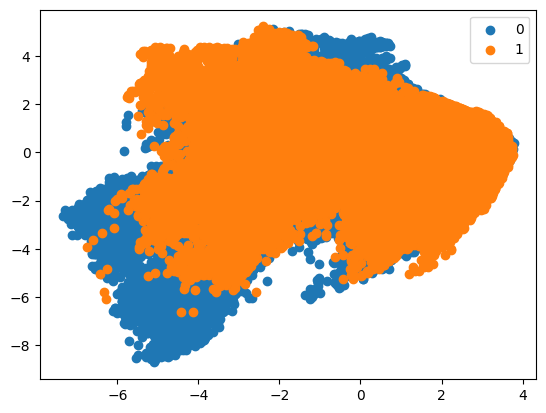

In [17]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (full_labels == 0)
mask_1 = (full_labels == 1)
plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], label="0")
plt.scatter(compressed_data[mask_1,0], compressed_data[mask_1,1], label="1")
plt.legend()
plt.show()

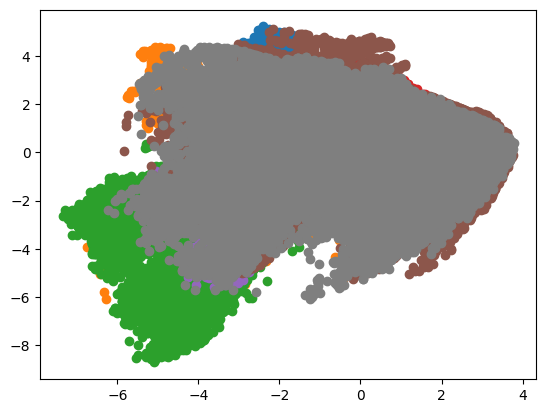

In [18]:
from cluster_tools import get_clusters

kmeans_clusters = get_clusters(dataset, logistic_label_01_process)

cluster_sampler = ClusterSampler(N, BATCH_SIZE, kmeans_clusters)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

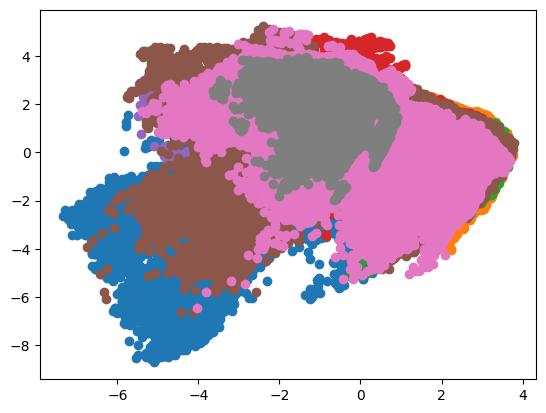

In [19]:
from cluster_tools import kmeans_cos_elbow

cos_clusters = get_clusters(dataset, logistic_label_01_process, kmeans_cos_elbow)
cosine_cluster_sampler = ClusterSampler(N, BATCH_SIZE, cos_clusters)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [20]:
def get_grad(batch, labels, model, criterion=log_01_criterion):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [21]:
# finding an exact solution

from tqdm import tqdm
from solvers import get_regularized_loss

model = SimpleModel(clustered_data)

def train_model_until(model, err, lr=2):
    curr_epoch = 0
    regularized_ls = []

    while 1:
        reg_loss = get_regularized_loss(model, 
                                        clustered_data, 
                                        full_labels, 
                                        log_01_criterion,
                                        LAMBDA)
        model.zero_grad()
        reg_loss.backward()
        for p in model.parameters():
            p.data.sub_(lr*(p.grad.data)) #+ LAMBDA*p.data))
        regularized_ls.append(reg_loss.item())
        curr_epoch += 1
        if curr_epoch % 1000 == 0:
            print(curr_epoch, reg_loss.item())
        if curr_epoch > 1 and regularized_ls[-2] - regularized_ls[-1] < err:
            break
    return curr_epoch, regularized_ls

curr_epoch, regularized_ls = train_model_until(model, 1e-11)
opt_val = regularized_ls[-1]
print(curr_epoch, opt_val)

195 0.5137895345687866


In [22]:
output = model(clustered_data)
model.zero_grad()
loss = log_01_criterion(output, full_labels)
loss.backward()
for p in model.parameters():
    print(2*(p.grad.data + LAMBDA*p.data))

tensor([[ 1.8764e-05,  1.1603e-06,  2.1201e-05, -3.5577e-06,  1.1729e-07,
         -2.4500e-06,  1.1221e-04, -7.2792e-05,  1.3440e-04,  7.4751e-07,
          4.6594e-06, -2.1237e-06, -1.3354e-06, -4.8769e-06,  3.5373e-04,
         -8.8297e-07,  3.7553e-07, -1.4704e-06,  2.5540e-04,  1.6346e-06,
         -5.7868e-05, -7.3815e-07, -1.3582e-06, -3.2060e-06, -4.4464e-06,
         -1.0098e-05, -5.6380e-06,  1.7113e-04,  1.0555e-05, -2.9703e-06,
         -1.4265e-06, -1.6337e-06, -4.4449e-06, -6.1425e-06, -2.5050e-06,
         -1.4272e-05, -1.6457e-05, -1.0731e-05, -1.4721e-06, -2.5929e-06,
         -2.0783e-06, -8.0050e-07, -2.4125e-05, -1.2257e-05, -1.0967e-05,
         -1.5339e-05, -1.3193e-05, -2.4909e-06,  2.9402e-06, -8.3351e-07,
          7.0618e-05, -1.2477e-05, -1.5409e-05, -1.0701e-05]])
tensor([4.3420e-05])


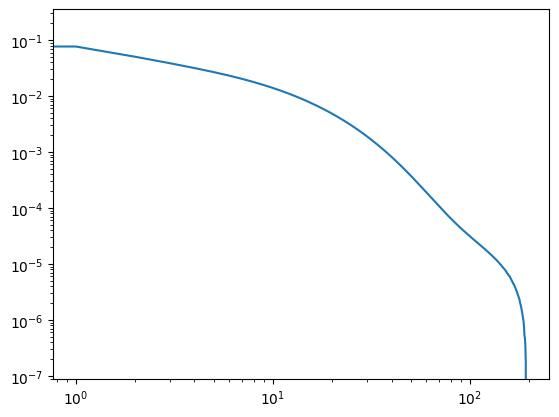

In [23]:
plt.plot(np.array(regularized_ls)-opt_val)
# plt.yscale("log")
plt.loglog()
plt.show()

Getting gradients closer to the objective, testing out if reclustering could in theory work

In [24]:
from cluster_tools import kmeans_pp_elbow

close_model = SimpleModel(clustered_data)
_ = train_model_until(close_model, 1e-4)
close_cluster_labels = kmeans_cos_elbow(get_grad(clustered_data, full_labels, close_model))
new_cluster_sampler = ClusterSampler(N, BATCH_SIZE, close_cluster_labels)

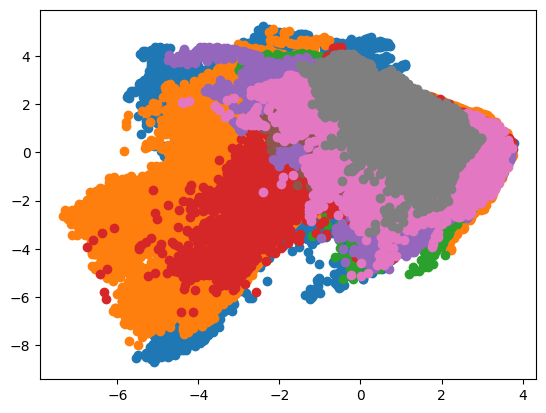

In [35]:
for i in range(new_cluster_sampler.cluster_count):
    selected = compressed_data[new_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

In [26]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [27]:
from utils import clone_model

In [28]:
base_model = SimpleModel(clustered_data)
lr = 2
lr_one_t = lambda epoch: 5 / (epoch+1)
lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [29]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

new_cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=new_cluster_sampler)

Clusters from linkage clustering

nb of clusters: 75
0.9852343841435289
2.0653618169676357e-05
0.0015800017899802413
2.2374753017149388e-05
9.466241661101664e-05
4.3028371186825744e-05
0.007863865118104274
0.0005094559148520169
1.72113484747303e-05
2.2374753017149388e-05
0.00011015263023827391
9.122014691607057e-05
5.5076315119136954e-05
0.00012736397871300422
9.638355145848967e-05
3.614383179693363e-05
8.777787722112453e-05
0.0002788238452906308
1.893248332220333e-05
5.5076315119136954e-05
2.409588786462242e-05
0.0008450772101092576
0.00013080624840795026
1.72113484747303e-05
5.335518027166392e-05
0.00015145986657762663
7.056652874639422e-05
1.72113484747303e-05
2.2374753017149388e-05
5.5076315119136954e-05
4.819177572924484e-05
2.7538157559568477e-05
2.5817022712095446e-05
1.893248332220333e-05
5.5076315119136954e-05
3.614383179693363e-05
6.540312420397513e-05
2.2374753017149388e-05
5.335518027166392e-05
2.5817022712095446e-05
4.819177572924484e-05
2.9259292407041508e-05
2.7538157559568477e-05
2.0653618169676357e-05


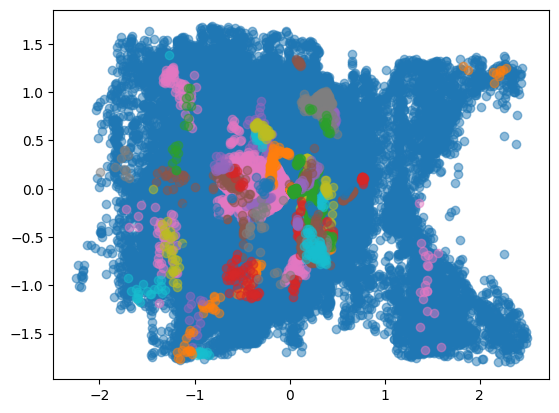

In [30]:
from cluster_tools import display_clusters, approx_nearest_clustering
from cluster_tools import alt_elbow

close_gradients = get_grad(clustered_data, full_labels, close_model)

# alt_cluster_labels = alt_elbow(labeled_data.detach().numpy())
alt_cluster_labels = approx_nearest_clustering(close_gradients)
alt_clusters = [[] for _ in range(max(alt_cluster_labels)+1)]
for i, j in enumerate(alt_cluster_labels):
    alt_clusters[j].append(i)

display_clusters(close_gradients, alt_cluster_labels, max(alt_cluster_labels)+1)

print("nb of clusters:", len(alt_clusters))
for c in alt_clusters:
    print(len(c)/N)

In [ ]:
from solvers import alt_solve_problem

# get number of thing per batch
v = np.zeros(len(alt_clusters))
for i in range(len(alt_clusters)):
    grads = np.mean(close_gradients[alt_clusters[i]], axis=0)
    v[i] = np.mean(np.sum((close_gradients[alt_clusters[i]] - grads)**2, axis=1))
v = torch.from_numpy(v)

_, alt_sol, _ = alt_solve_problem(base_model, 
                                  log_01_criterion,
                                  optimizer_class=torch.optim.SGD,
                                  datasource=dataset,
                                  cluster_labels=alt_cluster_labels,
                                  v_i=v,
                                  batch_size=BATCH_SIZE,
                                  n_epoch=200)

tensor([6.3828e+01, 3.0330e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.4199e-01], dtype=torch.float64) tensor([3982,    4,    1,    1,    1,    1,    1,    9], dtype=torch.int32) tensor([3.3237e-04, 7.4376e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2199e-04], dtype=torch.float64)


100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


Both for comparison and for checking if the learning rate works

In [31]:
_, sgd_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
    n_epoch=200
)

100%|██████████| 200/200 [30:03<00:00,  9.02s/it]


In [ ]:
from solvers import full_batch_corresp

_, regular_gd_sol, _ = full_batch_corresp(
    clone_model(base_model, clustered_data),
    log_01_criterion,
    torch.optim.SGD,
    dataset,
    BATCH_SIZE,
    n_epoch=50, 
    lr=lr,
    lr_lambda=lr_one_t,
    l2=LAMBDA
)

100%|██████████| 453950/453950 [48:48<00:00, 155.00it/s]


In [38]:
opt_val = min(opt_val, min(sgd_sol))
opt_val = min(opt_val, min(regular_gd_sol))

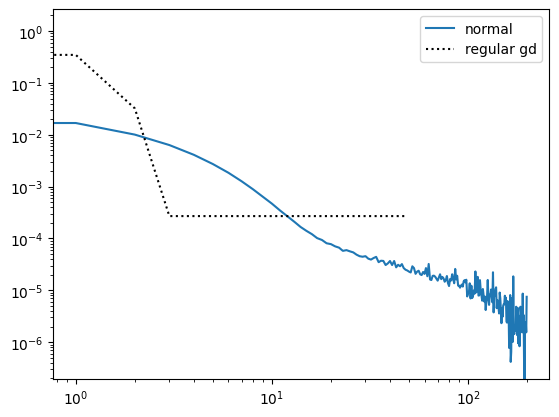

In [39]:
# plt.plot(alt_sol - opt_val, label="alt")
plt.plot(sgd_sol - opt_val, label="normal")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

plt.loglog()
plt.legend()
plt.show()

In [34]:
def repeat_exec(base_model,
                model_arg,
                criterion,
                optimizer_class,
                dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                repeat_times=REPEAT_TIMES,
                lr=lr,
                lr_lambda=lr_one_t,
                l2=LAMBDA):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(
            clone_model(base_model, model_arg), 
            criterion,
            optimizer_class,
            dataloader,
            n_epoch,
            time_lim,
            verbose,
            lr,
            lr_lambda,
            l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [31]:
# sgd_times, sgd_sols = repeat_exec(
#     base_model, clustered_data, 
#     log_01_criterion,
#     optimizer_class=torch.optim.SGD,
#     dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
#     n_epoch=1000,
#     repeat_times=1
    
# )
# plt.plot(sgd_sols[0]-opt_val, color="blue", label=None)
# plt.loglog()
# plt.show()

In [ ]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:34<320:36:28, 11.54s/it]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data)),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True,
    lr=lr,
    # lr_lambda=lr_log_t,
    )

Building models...


  0%|          | 158/100000 [00:30<5:18:07,  5.23it/s]


In [35]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], reduced[lims[i]:lims[i+1],1], alpha=0.5)
    plt.title(title)
    plt.show()

In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:39<363:39:27, 13.09s/it]


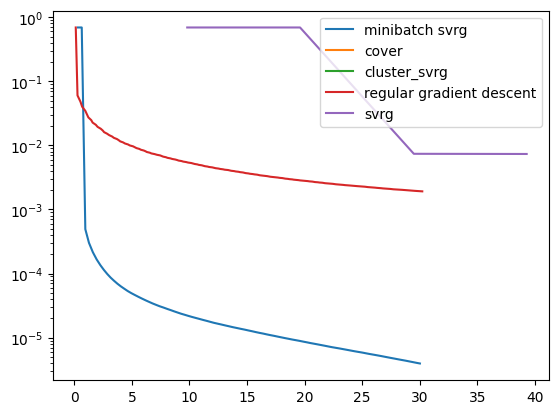

In [ ]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [36]:
sgd_times, sgd_sols = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
)

Building models...


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.24it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


In [ ]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True,
              lr=lr,
              lr_lambda=lr_log_t)

In [ ]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [37]:
sgd_iid_times, sgd_sols_iid = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
)

Building models...


100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


Building models...


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Building models...


100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


Building models...


100%|██████████| 100/100 [00:06<00:00, 14.36it/s]


In [38]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cluster_dataloader,
)

Building models...


100%|██████████| 100/100 [00:08<00:00, 12.30it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


In [39]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cosine_dataloader,
)

Building models...


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


Building models...


100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


In [40]:
sgd_bis_times, sgd_bis = repeat_exec(
    base_model, clustered_data, 
    log_01_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=new_cluster_dataloader,
    # n_epoch=NB_EPOCH*20,
    # repeat_times=1
)

Building models...


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Building models...


100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


In [137]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [138]:
# plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
# plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
# plt.plot(sgd_cosine_time, sgd_sol_cosine-opt_val, label="cosine", alpha=0.8)
# plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)

# plt.legend()
# plt.yscale("log")
# plt.xlabel("time (s)")
# plt.title("using SGD with different sampling techniques")
# plt.show()

In [ ]:
# folder = "./saves/"
# exp_type = "MNIST_01_" #"MNIST_01_"
# bis = "(3)"
# ext = "b" + str(BATCH_SIZE) + bis + ".txt"

In [ ]:
# execution_res_names = ["sgd_sols_iid", "sgd_sols_cluster", "sgd_sols_cosine", "sgd_sols"]
# file_names = ["sgd_iid_", "sgd_clustered_", "cosine_", ""]

In [46]:
# for ref, name in zip(execution_res_names, file_names):
#     exec(ref + " = np.loadtxt(folder + exp_type + name + ext)")

In [ ]:
# for ref, name in zip(execution_res_names, file_names):
#     exec("np.savetxt('" + folder + exp_type + name + ext + "', np.array(" + ref + "))")

In [41]:
for losses in [sgd_sols_iid, sgd_sols_cluster, sgd_sols_cosine, sgd_sols]:
    for l in losses:
        opt_val = min(opt_val, min(l))
opt_val

0.005683212541043758

In [47]:
def plot_mult_iter(losses, opt_val, color, label):
    ls = np.array(losses)
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.3, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(m-opt_val, color=color, label=label, alpha=0.9)
    # plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

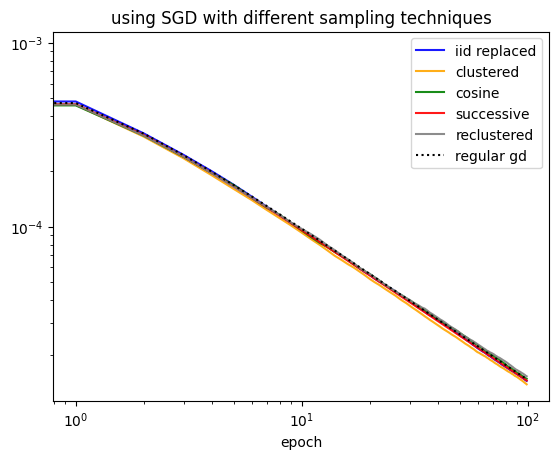

In [53]:
plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")
plot_mult_iter(sgd_bis, opt_val, color="grey", label="reclustered")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

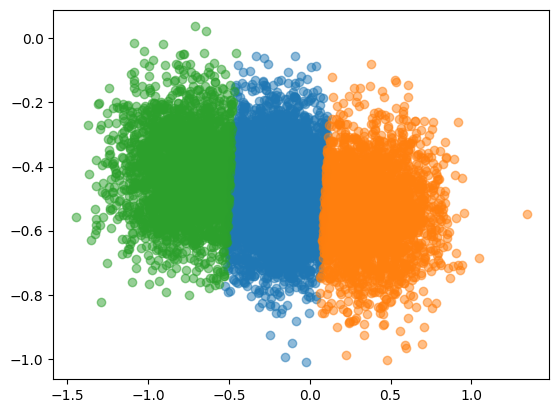

In [ ]:
display_grads(dataset, SimpleModel(clustered_data), cluster_sampler)

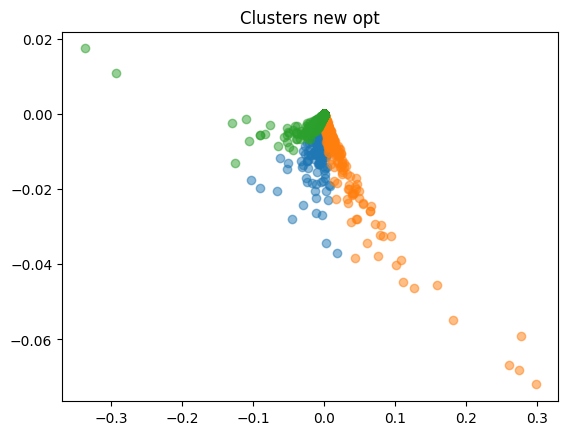

In [ ]:
display_grads(dataset, model, cluster_sampler, title="Clusters new opt")

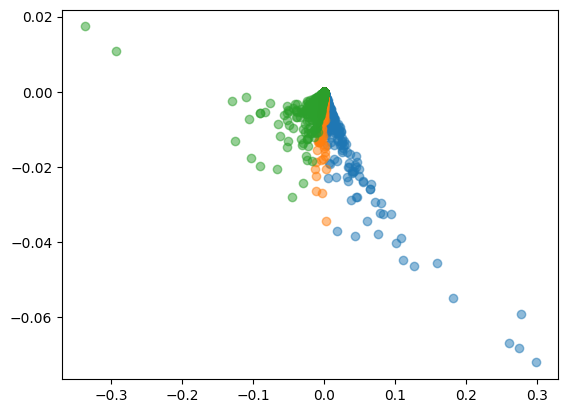

In [ ]:
display_grads(dataset, model, cosine_cluster_sampler)

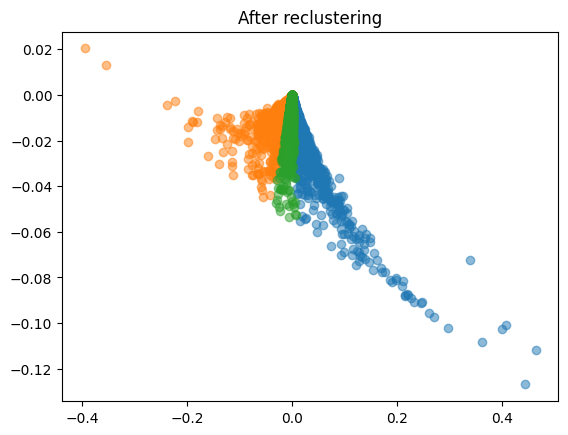

In [ ]:
display_grads(dataset, close_model, new_cluster_sampler, title="After reclustering")

In [ ]:
all_gradients = get_grad(clustered_data, full_labels, model)

In [ ]:
def alt_objective(clusters, all_gradients):
    # objective function associated with the alternative "kmeans"
    #  from https://arxiv.org/abs/1405.3080
    res = 0
    n = len(all_gradients)
    for cluster in clusters:
        grads = np.mean(all_gradients[cluster], axis=0)
        res += np.sqrt(len(cluster)*np.sum((all_gradients[cluster] - grads)**2))
    return res / (n**2)

print(alt_objective(alt_clusters, all_gradients))
print(alt_objective(cluster_sampler.clusters, all_gradients))

1.0378202818051112e-06
2.593057770926122e-06


In [ ]:
from torch.utils.data import Sampler

# calculates the actual variance 
def batch_variance(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    grad = np.mean(batch_grads, axis=0)
    return np.mean(np.sum((batch_grads - grad)**2, axis=1))

full_dataset_var = batch_variance(clustered_data, full_labels, model)
print("full dataset variance:", full_dataset_var)

full dataset variance: 0.000103650775


In [ ]:
def analyse_sampler(sampler:ClusterSampler, dataset:DataLoader, model, caption=None):
    if caption is not None:
        print(caption)
    batch_size = sum(sampler.sample_count) + sampler.added_count
    print("batch", batch_size, "added:", sampler.added_count)
    variances = np.zeros(sampler.cluster_count)
    for i, cluster in enumerate(sampler.clusters):
        batch, labels = dataset[cluster]
        variances[i] = batch_variance(batch, labels, model)
        print(sampler.cluster_sizes[i], 
              sampler.sample_count[i], 
              variances[i])
    avg = np.sum(variances*np.array(sampler.sample_count))/(batch_size - sampler.added_count)
    avg += sampler.added_count / sampler.num_samples * full_dataset_var
    print("average:", avg)

In [ ]:
analyse_sampler(cluster_sampler, dataset, model, "Cluster variances")
analyse_sampler(cosine_cluster_sampler, dataset, model, "Cosine cluster variances")
analyse_sampler(new_cluster_sampler, dataset, model, "Recluster variances")

Cluster variances
batch 64 added: 1
4613 29 1.7082697013393044e-05
2725 17 0.00021569081582129002
2662 17 0.00012840601266361773
average: 0.00010072535392876792
Cosine cluster variances
batch 64 added: 1
2827 18 0.00020935495558660477
3643 23 3.6331732644612202e-06
3530 22 0.00011315799929434434
average: 0.00010066795507932729
Recluster variances
batch 64 added: 1
2814 18 0.00021027663024142385
3570 22 0.00011193416867172346
3616 23 3.673004812299041e-06
average: 0.00010051846294741226


In [ ]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)

In [ ]:
# checking the variance, see how much it's reduced...
def histogram(dataloader:DataLoader, full_grad=None, label=None):
    res = []

    if full_grad is None:
        data, labels = dataloader.dataset.tensors
        full_grad = np.mean(get_grad(data, labels, model), axis=0)

    print("calculating for {}".format(label))
    for _ in range(10):
        for (batch, labels) in dataloader:
            batch_grads = get_grad(batch, labels, model)
            res.append(np.sum((np.mean(batch_grads, axis=0) - full_grad)**2))
        res.pop() # the last batch is size n%batch_size which is usually not batch_size 
                  # so we exclude it
    return res
    # plt.hist(res, density=True, label=label, alpha=1, histtype="step")
    # return np.array(res)
    
res_iid = histogram(iid_dataloader, full_grad, "iid")
res_cluster = histogram(cluster_dataloader, full_grad, "cluster")
res_cos = histogram(cosine_dataloader, full_grad, "cosine")
res_successive = histogram(DataLoader(dataset, BATCH_SIZE), full_grad, "successive")
res_reclustered = histogram(new_cluster_dataloader, full_grad, "recluster")

calculating for iid
calculating for cluster
calculating for cosine
calculating for successive
calculating for recluster


In [ ]:
for lab, res, color in zip(["iid","cluster", "cos", "successive", "reclus"],
                    [res_iid, res_cluster, res_cos, res_successive,res_reclustered],
                    ["blue", "orange", "green", "red", "gray"]):
    if len(res) == 1:
        r = res[0]
    else:
        r = res
    print(lab, np.mean(res)) # variances of the batches

iid 2.3135847e-06
cluster 2.3418027e-06
cos 2.6071862e-06
successive 4.2348665e-06
reclus 3.2267076e-06


Is the variance the problem?

Note that if the variance is really negligible then convergence should look like regular gradient descent

In [56]:
def batch_sq_mean(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    return np.mean(np.sum(batch_grads**2, axis=1))

In [140]:
from torch.optim.lr_scheduler import LambdaLR

EXP_NB_EPOCH = 80
EXP_BATCH_SIZE = 64

m_gd = SimpleModel(clustered_data)
m_sgd = SimpleModel(clustered_data)

optim_gd = torch.optim.SGD(m_gd.parameters(), lr=1, weight_decay=LAMBDA)
schedul_gd = LambdaLR(optim_gd, lr_lambda=lr_one_t)

optim_sgd = torch.optim.SGD(m_sgd.parameters(), lr=1, weight_decay=LAMBDA)
schedul_sgd = LambdaLR(optim_sgd, lr_lambda=lr_one_t)
loader = DataLoader(dataset, batch_size=EXP_BATCH_SIZE, sampler=iid_sampler)

gd_losses = []
sgd_losses = []
var_over_time = []

for epoch in tqdm(range(EXP_NB_EPOCH)):
    for (batch, labels) in loader:
        # matching the number of iterations for full batch
        pred1 = m_gd(clustered_data)
        l1 = log_01_criterion(pred1, full_labels)
        optim_gd.zero_grad()
        l1.backward()
        optim_gd.step()
        # batches
        pred2 = m_sgd(batch)
        l2 = log_01_criterion(pred2, labels)
        optim_sgd.zero_grad()
        l2.backward()
        optim_sgd.step()
    variance = batch_variance(clustered_data, full_labels, m_sgd)/EXP_BATCH_SIZE #batch_sq_mean(clustered_data, full_labels, m_sgd)
    
    schedul_gd.step()
    gd_losses.append(get_regularized_loss(m_gd, 
                                          clustered_data, 
                                          full_labels,
                                          log_01_criterion,
                                          LAMBDA).item())

    schedul_sgd.step()
    var_over_time.append(variance)
    sgd_losses.append(get_regularized_loss(m_sgd, 
                                           clustered_data, 
                                           full_labels,
                                           log_01_criterion,
                                           LAMBDA).item())


100%|██████████| 80/80 [03:47<00:00,  2.84s/it]


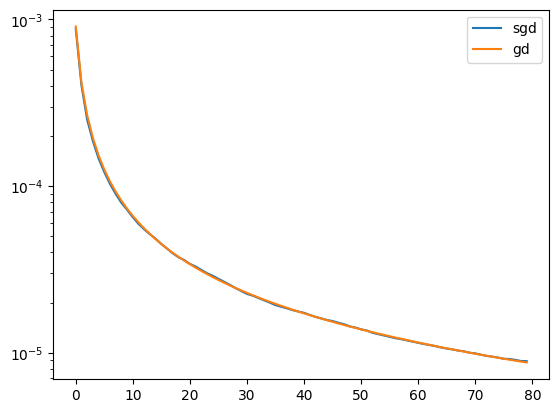

In [ ]:
plt.plot(np.array(sgd_losses)-opt_val, label="sgd")
plt.plot(np.array(gd_losses)-opt_val, label="gd")
plt.legend()
plt.loglog()
plt.show()

In [92]:
model_norm = 0
for p in model.parameters():
    model_norm += (p.data**2).sum()
model_norm = model_norm.item()
model_norm

74.69375610351562

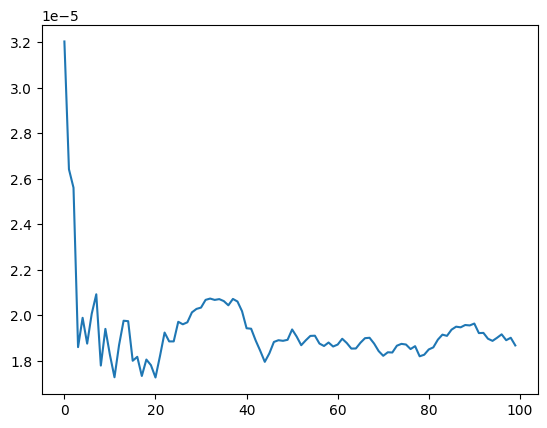

In [106]:
plt.plot(var_over_time)

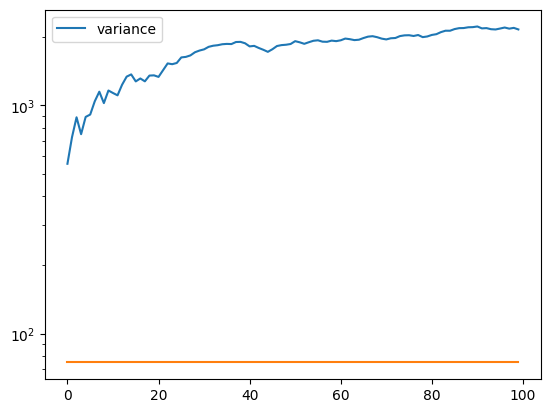

In [107]:
linspace = np.arange(EXP_NB_EPOCH)

plt.plot(np.log(linspace+2)*var_over_time/(2*LAMBDA)**2, label="variance")
plt.plot([model_norm]*EXP_NB_EPOCH)
plt.yscale("log")
plt.legend()
plt.show()

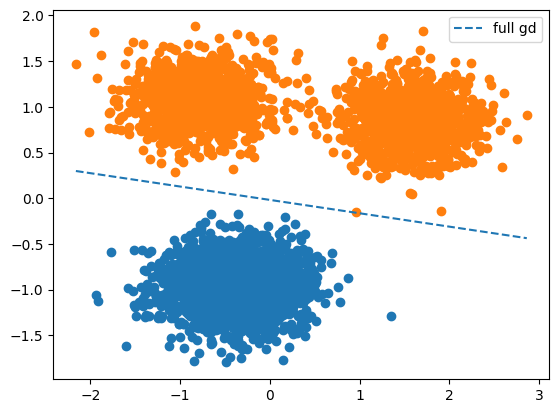

In [61]:
def plot_decision_boundary(data, model, label=None):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, '--', label=label)
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', label=label)

plot_decision_boundary(clustered_data, model, "full gd")
# plot_decision_boundary(clustered_data, test_m, "test")

plt.scatter(clustered_data[mask_0, 0], clustered_data[mask_0, 1])
plt.scatter(clustered_data[mask_1, 0], clustered_data[mask_1, 1])
plt.legend()
plt.show()

In [32]:
def test_sampler_speed(sampler):
    ITER_COUNT = 10
    dataloader = DataLoader(dataset, BATCH_SIZE, sampler=sampler)
    begin = time.perf_counter()
    for i in range(ITER_COUNT):
        for (batch, labels) in dataloader:
            pass
    end = time.perf_counter()
    print((end - begin)/ITER_COUNT)

In [ ]:
test_sampler_speed(None)
test_sampler_speed(RandomSampler(dataset))
test_sampler_speed(ClusterSampler(dataset, BATCH_SIZE, logistic_label_01_process))

0.1565863200000422
